# Projet Recherche Opérationelle - Branch And Bound

## Importation des modules

In [1]:
conda install pydot

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [68]:
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt

## Structure de données

In [3]:
class Node:
    
    def __init__(self,idx, parent, children, lb, visited):
        self.idx = idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
        
    def __str__(self):
        return ("Parent : " +str(self.parent)+
                "\n Children : "+str(self.children) + 
                "\n lb : "+str(self.lb)+ 
                "\n visited : "+str(self.visited))

In [145]:
def arborescence(node,Tree):
    branch = []
    while node.parent != None:
        branch.append(node.idx)
        node = node.parent
    branch.append(node.idx)
    
    return branch

In [4]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

In [5]:
def computeCost(p,d,w,order):
    t=0
    cost=0
    for idx in order:
        t += p[idx]
        cost += max(0,(t-d[idx])*w[idx])
    return cost

In [6]:
computeCost(pj,dj,wj,[0,1,3,2])

67

In [7]:
def getPrimal_0(p,d,w):
    sortedTasks=(np.argsort((np.array(d)-np.array(p))*np.array(w)))[::-1]
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)

def getPrimal_1(p,d,w):
    sortedTasks=np.argsort(d)
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)

def getPrimal_2(p,d,w):
    tasksLeft=[int(i) for i in range(len(p))]
    order=[]
    while len(tasksLeft)!= 0:
        time=np.sum(np.array(p)[tasksLeft])
        penalities=(time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks=np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,order)
    return(cost,order)

In [8]:
print("Temps production : ", pj)
print("Date limite :      ", dj)
print("Pénalités :        ", wj)
print("0 : ",getPrimal_0(pj,dj,wj))
print("1 : ",getPrimal_1(pj,dj,wj))
print("2 : ",getPrimal_2(pj,dj,wj))

Temps production :  [12, 8, 15, 9]
Date limite :       [16, 26, 25, 27]
Pénalités :         [4, 5, 3, 5]
0 :  (133, array([3, 1, 2, 0]))
1 :  (136, array([0, 2, 1, 3]))
2 :  (67, [0, 1, 3, 2])


In [10]:
def getDual_0(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    for j in notVisited:
        retard=(p[j]+time)-d[j]
        dual+=retard*w[j]*(retard>0)
    return dual

def getDual_1(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    return dual

def getDual_2(p,d,w,visited):
    dual=0
    time=np.sum(p)

    for i in visited:
        retard=(time-d[i])
        dual+=retard*w[i]*(retard>0)
        time-=p[i]
        
    return dual

In [11]:
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : \n",
      getDual_0(pj,dj,wj,[2,3]))
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : \n",
      getDual_1(pj,dj,wj,[2,3]))

Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : 
 110
Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : 
 0


In [12]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    return(Queue[-1])

def exploration_2(Queue,Tree,UB):
    bestNode = None
    bestLB = -math.inf
    for i in range(len(Queue)):
        if Tree[Queue[i]].lb > bestLB and Tree[Queue[i]].lb < UB:
            bestLB = Tree[Queue[i]].lb
            bestNode = i
    return(Queue[i])

# Branch and Bound

In [15]:
def branch_and_bound_display(p,d,w,byLast,getPrimal,getDual,exploration,steps):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)
    if steps:
        print("First UB : ", UB)
    
    root = Node(0,None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        

        # process the first node in the queue

        currentIndex = exploration(Queue,Tree,UB)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if nbIterations == 1e4:
            print("UB : ", UB)
            print(currentNode)
        if nbIterations == 2e5:
            print("UB : ", UB)
            print(currentNode)
        if nbIterations == 2e5:
            print("UB : ", UB)
            print(currentNode)
        
        if steps:
            print("##################################")
            print("Current Node : {}\n".format(currentIndex),currentNode )
        
        if len(currentNode.visited) == len(p):
            order = copy.copy(currentNode.visited)
            if byLast:
                order.reverse()
            solutionCost = computeCost(p,d,w,order)
            if solutionCost <= UB:
                UB = solutionCost
                currentOrder=order
                
        if currentNode.lb < UB:
            for nextTask in (set(Tasks)-set(currentNode.visited)):
                nextVisited = copy.copy(currentNode.visited)
                nextVisited.append(nextTask)
                nextLb = getDual(p,d,w, nextVisited)
                
                newNode = Node(len(Tree)-1,currentNode, [], nextLb,nextVisited)
                Tree.append(newNode)
                Queue.append(len(Tree)-1)
                currentNode.children.append(newNode)
        else:
            if steps:
                print("Prune : ", currentIndex)
        
        # Calculate the current LB as the maximum of all the upper bounds among the active nodes
        currentLB = -math.inf
        for node in Tree:
            if node.lb > currentLB and node.lb <= UB:
                currentLB = node.lb
        
        # Update the LB if the current LB is better
        if currentLB >= LB:
            LB = currentLB
        
        # Display the current upper and lower bounds    
        if steps:
            print("LB= ",LB," UB= ", UB)
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    print("Number of iterations : ", nbIterations)
    
    return UB, currentOrder

In [249]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)

    bestNode = Node("",-1, [], 0 ,[])
    
    root = Node("P",None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        
        # process the first node in the queue

        currentIndex = exploration(Queue,None,None)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if currentNode.lb < UB:
            
            if len(currentNode.visited) == len(p):
                order = currentNode.visited.copy()
                if byLast:
                    order.reverse()
                solutionCost = computeCost(p,d,w,order)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder=order
                    bestNode = currentNode
            else:
                for nextTask in (set(Tasks)-set(currentNode.visited)):
                    nextVisited = currentNode.visited.copy()
                    nextVisited.append(nextTask)
                    nextLb = getDual(p,d,w, nextVisited)

                    newNode = Node("",currentNode, [], nextLb,nextVisited)
                    
                    if currentNode.visited!=[]:
                        newNode.idx="P("
                        for i in range(len(nextVisited)-1):
                            newNode.idx+=str(nextVisited[i])+","
                        newNode.idx+=str(nextVisited[len(nextVisited)-1])+")"
                    else:
                        newNode.idx="P("+str(nextTask)+")"
                        
                    Tree.append(newNode)
                    Queue.append(len(Tree)-1)
                    currentNode.children.append(newNode)
            
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    
    if 2*(UB-bestNode.lb)<=0.0001:
        branch = arborescence(bestNode,Tree)
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

In [250]:
def displayTree(Tree,currentOrder,branch,byLast):
    
    index=['P']
    parent=['P']
    for node in Tree:
        if(node.idx!="P"):
            index.append(node.idx)
            parent.append((node.parent).idx)
    graphe=dict(zip(index,parent))
    
    graph=nx.Graph()
    graph.add_nodes_from(index)
    for idx in graphe.keys():
        graph.add_edge(idx,graphe[idx])
        
    if(byLast==True):
        branch.reverse()

    bestPath= set(zip(branch[:-1], branch[1:]))
    edge_colors=dict()
    for edge in graph.edges():
        if edge in bestPath:
            edge_colors[edge]='red'
        else:
            edge_colors[edge]='lightblue'
            
    node_colors=dict()
    for node in graph.nodes():
        if node in branch:
            node_colors[node]='red'
        else:
            node_colors[node]="lightblue"
    
    plt.figure(figsize=(12,8))
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos,with_labels=True,node_size=1200,node_color=node_colors.values(),edge_color=edge_colors.values())
    plt.show()

### Test de la fonction display

In [251]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


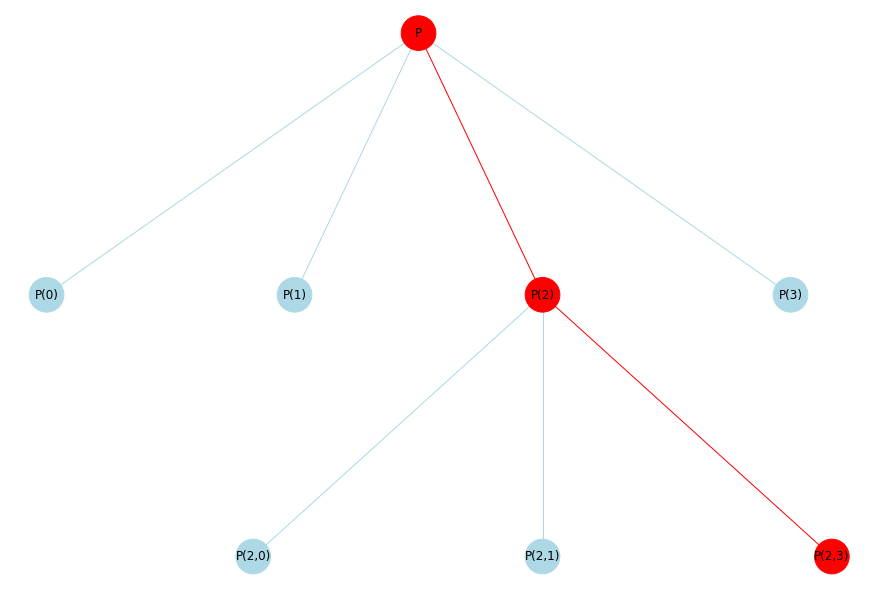

In [252]:
solution,order,nbIterations,branch,Tree=branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_0)
displayTree(Tree,order,branch,True)


In [253]:
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, False, getPrimal_1, getDual_1,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, False, getPrimal_2, getDual_1,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_1, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_1, getDual_2,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_0, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_0, getDual_2,exploration_1)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_0)
print(nbIterations)
solution, order, nbIterations,branch,Tree = branch_and_bound(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_1)
print(nbIterations)

65
59
44
17
38
17
8
8


## Test de notre fonction Branch-And-Bound : 

In [254]:
def genInstancies(n):
    p=np.random.randint(1,15,n)
    d=np.random.randint(3,int(0.5*n*15),n)
    w=np.random.randint(1,5,n)
    return(p,d,w)

p :  [7 5 8 8 1 6]
d :  [ 4 14 36 42 19 34]
w :  [3 3 1 3 1 2]
Final Results: 168 Iterations
Order : [0, 1, 4, 2, 5, 3] | Cost : 9
['P(3,5,2,4,1,0)', 'P(3,5,2,4,1)', 'P(3,5,2,4)', 'P(3,5,2)', 'P(3,5)', 'P(3)', 'P']


/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


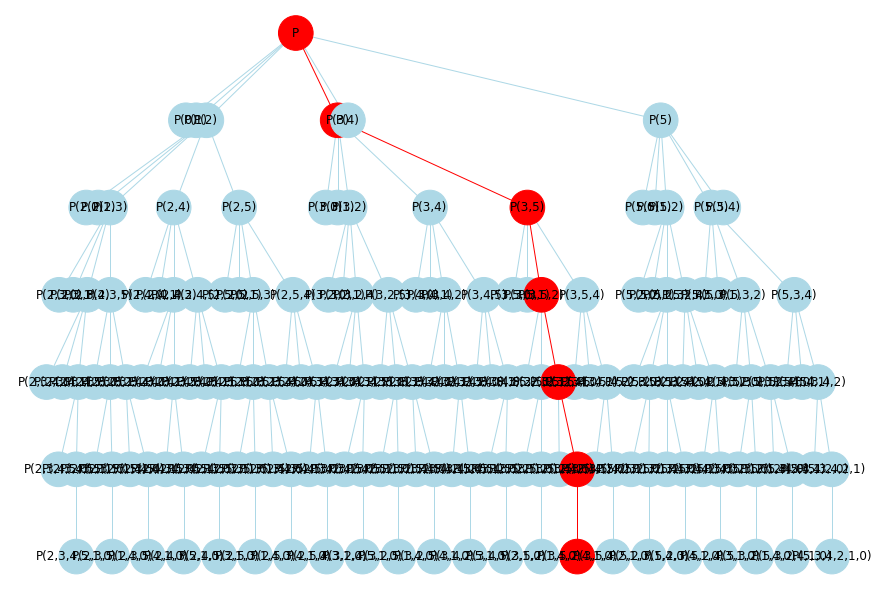

In [258]:
p,d,w = genInstancies(6)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))
print(branch)
displayTree(Tree,order,branch,True)


In [259]:
p,d,w = genInstancies(15)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))

p :  [ 4  7  4 12  1 11 11  5  3 11 10  9  3  5  3]
d :  [37 31  3 28 42 37 14 89 64 74 72 84  4 22 10]
w :  [4 4 3 2 4 1 3 3 2 3 3 2 1 2 4]
Final Results: 137647 Iterations
Order : [2, 12, 14, 6, 13, 1, 0, 4, 3, 8, 10, 9, 11, 7, 5] | Cost : 149
